##import

In [1]:
%tensorflow_version 2.x
from keras.datasets import imdb
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ADDRESS_PREDICT_SIZE = 1001
EMBEDDING_DIM = 64
RNN_UNITS = 1024
FIRST_OUTPUT_SIZE = 1001
BUFFER_SIZE = 10000
BATCH_SIZE = 64

##change hyperparameter to make best model

In [3]:
seq_length = 5 # length of sequence for a training example
epoch = 30
MAXLEN = 43
DENSE_HIDDEN_SIZE = 20
train_model_percentage = 80

##open text file

In [4]:
f = open("473.astar-s0.txt", 'r')

##text file split

In [5]:
unique_instr_id = list()
cycle_count = list()
load_address = list()
instr_pointer_load = list()
llc_hit_miss = list()

f.seek(0, 0)
while True:
  line = f.readline()
  if not line: break
  split_line = line.split(', ')
  unique_instr_id.append(split_line[0])
  cycle_count.append(split_line[1])
  load_address.append(split_line[2])
  instr_pointer_load.append(split_line[3])
  llc_hit_miss.append(split_line[4][:-1])

for i in range(len(load_address)):
  load_address[i] = int(load_address[i], 16)//64

##make delta list(first input)

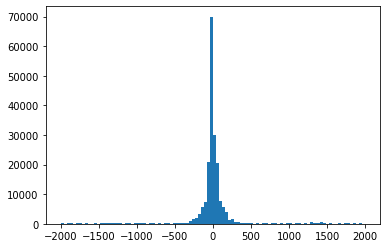

[687, 312, 445, 755, 611, 566, 515, 584, 334, 698, 576, 584, 544, 164, 903, 564, 582, 532, 1000, 0, 969, 436, 1000, 591, 564, 0, 1000, 0, 531, 1000, 586, 532, 510, 586, 0, 1000, 618, 564, 513, 532, 583, 516, 564, 564, 564, 597, 532, 532, 0, 1000, 751, 564, 602, 532, 532, 526, 564, 563, 0, 1000, 564, 602, 532, 532, 404, 622, 564, 0, 1000, 564, 597, 531, 437, 370, 768, 564, 589, 532, 571, 461, 603, 301, 763, 589, 0, 1000, 0, 1000, 1000, 0, 532, 347, 685, 1000, 0, 781, 0, 1000, 563, 501]
4363500794111
[[ 687  312  445  755  611  566]
 [ 312  445  755  611  566  515]
 [ 445  755  611  566  515  584]
 ...
 [1000  499    0  554  501 1000]
 [ 499    0  554  501 1000  499]
 [   0  554  501 1000  499    0]]
[[ 687  312  445  755  611]
 [ 312  445  755  611  566]
 [ 445  755  611  566  515]
 ...
 [1000  499    0  554  501]
 [ 499    0  554  501 1000]
 [   0  554  501 1000  499]]


In [6]:
delta = list()
for i in range(len(load_address)-1):
  delta.append(load_address[i+1] - load_address[i])

plot_this = list()
for i in range(len(load_address)-1):
  if delta[i] > 2000:
    continue
  if delta[i] < -2000:
    continue
  plot_this.append(delta[i])
plt.hist(plot_this, bins=100)
plt.show()

for i in range(len(delta)):
  if delta[i] > 500:
    delta[i] = 1000
    continue
  if delta[i] < -500:
    delta[i] = 0
    continue
  delta[i] += 500

print(delta[0:100])
print(max(load_address))

delta_bundle = list()
for i in range(len(delta)-seq_length-1):
  delta_bundle.append(delta[i:i+seq_length+1])
delta_bundle = np.array(delta_bundle)
print(delta_bundle)

rnn_data = delta_bundle[:,:-1]
rnn_data = np.array(rnn_data)
print(rnn_data)

##make address binary input(second input)

In [7]:
# 8 -> [0,0,0,1] change int to categorical value
def address_to_binary(a):
  binary_int = list()
  for i in range(MAXLEN):
    # /1000 -> scaling
    binary_int.append(a%2)
    a = a//2
  return binary_int

print(address_to_binary(8))

address_binary_input = list()
for i in range(seq_length+1, len(load_address)-1):
  address_binary_input.append(address_to_binary(load_address[i]))

print(address_binary_input[0])
address_binary_input = np.array(address_binary_input)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


##make output data

In [8]:
delta_output = delta_bundle[:,-1:]
delta_output = delta_output.flatten()
delta_output

array([ 566,  515,  584, ..., 1000,  499,    0])

##kick dummy input and output

In [9]:
delete_list = list()
for i in range(len(delta_output)):
  if delta_output[i] == 0 or delta_output[i] == 1000:
    delete_list.append(i)

delta_output = np.delete(delta_output, delete_list)
rnn_data = np.delete(rnn_data, delete_list, 0)
address_binary_input = np.delete(address_binary_input, delete_list, 0)

print(delta_output)

[566 515 584 ... 554 501 499]


##make model

In [10]:
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model

def build_model(address_predict_size, first_output_size, embedding_dim, rnn_units, Batch_size):
  
  input_x = Input(shape=(seq_length,))
  x = Embedding(address_predict_size, embedding_dim)(input_x)
  x = LSTM(rnn_units, recurrent_initializer='glorot_uniform') (x)
  x = Dense(first_output_size, activation="sigmoid") (x)
  x = Model(inputs=input_x, outputs=x)

  input_y = Input(shape=(MAXLEN,))
  y = Dense(16, activation="relu")(input_y)
  y = Model(inputs=input_y, outputs=y)

  combined = tf.keras.layers.concatenate([x.output, y.output])

  z = Dense(128, activation="relu")(combined)
  z = Dense(address_predict_size, activation="sigmoid")(z)

  model = Model(inputs=[x.input, y.input], outputs=z)

  return model

model = build_model(ADDRESS_PREDICT_SIZE, FIRST_OUTPUT_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 256)       256256      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1024)         5246976     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 43)]         0                                            
____________________________________________________________________________________________

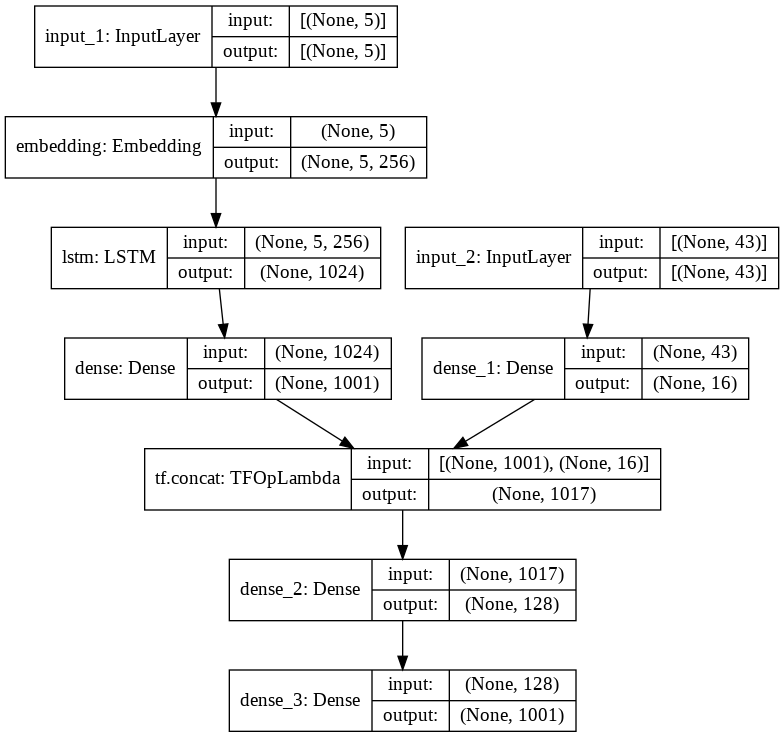

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

##create loss function

In [12]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [13]:
model.compile(optimizer='adam', loss=loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [15]:
history = model.fit([rnn_data, address_binary_input], delta_output, batch_size=BATCH_SIZE, epochs=epoch, callbacks=[checkpoint_callback])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


2903/2903 [==============================] - 49s 9ms/step - loss: 3.5044
Epoch 2/30
2903/2903 [==============================] - 29s 10ms/step - loss: 3.0426
Epoch 3/30
2903/2903 [==============================] - 30s 10ms/step - loss: 2.8420
Epoch 4/30
2903/2903 [==============================] - 29s 10ms/step - loss: 2.6610
Epoch 5/30
2903/2903 [==============================] - 29s 10ms/step - loss: 2.4884
Epoch 6/30
2903/2903 [==============================] - 30s 10ms/step - loss: 2.3381
Epoch 7/30
2903/2903 [==============================] - 29s 10ms/step - loss: 2.1997
Epoch 8/30
2903/2903 [==============================] - 29s 10ms/step - loss: 2.0718
Epoch 9/30
2903/2903 [==============================] - 29s 10ms/step - loss: 1.9639
Epoch 10/30
2903/2903 [==============================] - 29s 10ms/step - loss: 1.8646
Epoch 11/30
2903/2903 [==============================] - 29s 10ms/step - loss: 1.7736
Epoch 12/30
2903/2903 [==============================] - 30s 10ms/step - lo

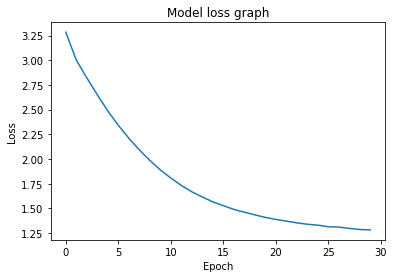

In [16]:
plt.plot(history.history['loss'])
plt.title('Model loss graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
# expand_dims [10,10,3] -> [1,10,10,3]
input1 = tf.expand_dims([687, 312, 445, 755, 611], 0)
input2 = tf.expand_dims([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],0)

input_eval = [input1, input2]
temperature = 1.0
model.reset_states()

prediction = model(input_eval)
print(prediction)

prediction = prediction / temperature
print(prediction)

predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
print(predicted_id)

tf.Tensor(
[[2.1285739e-13 5.9269603e-28 2.4380320e-27 ... 5.7150063e-15
  5.2476801e-10 2.2553559e-13]], shape=(1, 1001), dtype=float32)
tf.Tensor(
[[2.1285739e-13 5.9269603e-28 2.4380320e-27 ... 5.7150063e-15
  5.2476801e-10 2.2553559e-13]], shape=(1, 1001), dtype=float32)
225


In [18]:
def generate_address(model, start_address):
  # Evaluation step (generating address using the learned model)

  # Number of characters to generate
  num_generate = 2

  input_eval = [tf.expand_dims(start_address[0], 0), tf.expand_dims(start_address[1], 0)]

  # Empty string to store our results
  generated = []

  # Low temperatures results in more predictable.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  
  predictions = model(input_eval)

  predictions = predictions / temperature

  # using probability
  '''
  generated = tf.random.categorical(predictions_np, num_samples=num_generate)[-1,0].numpy()  
  '''

  # using argmax
  predictions_np = predictions.numpy()
  predictions_np = np.squeeze(predictions_np,axis=0)
  predictions_np = np.argsort(predictions_np)
  generated = predictions_np [-num_generate:]

  return generated

In [19]:
inp = [[687, 312, 445, 755, 611],[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]]
print(generate_address(model, inp))

[467 532]


##accuracy 측정

In [22]:
total_num = len(load_address) - seq_length
total_num_except_0_1000 = 0
correct = 0
first_correct = 0
second_correct = 0

for i in tqdm(range(len(delta_output)), desc='check accuracy..'):
  total_num_except_0_1000 += 1
  inp = [rnn_data[i].tolist(), address_binary_input[i].tolist()]
  lstm_ans = generate_address(model, inp)
  if delta_output[i] in lstm_ans:
    correct += 1
    if delta_output[i] == lstm_ans[0]:
      first_correct += 1
    if delta_output[i] == lstm_ans[1]:
      second_correct += 1

print("accuracy")
print(correct/total_num)
print("accuracy except 0 and 1000")
print(correct/total_num_except_0_1000)
print("first number accuracy")
print(first_correct/total_num_except_0_1000)
print("second number accuracy")
print(second_correct/total_num_except_0_1000)

check accuracy..: 100%|██████████| 185741/185741 [19:47<00:00, 156.47it/s]

accuracy
0.201963227254018
accuracy except 0 and 1000
0.7845871401575312
first number accuracy
0.07302103466655181
second number accuracy
0.7115661054909794


#seq_length = 5
###epoch = 10
#####accuracy: 3.96%
#####accuracy except 0 and 1000: 15.3%
###epoch = 20
#####accuracy: 4.39%
#####accuracy except 0 and 1000: 17.05%
###epoch = 30
#####accuracy: 4.51%
#####accuracy except 0 and 1000: 17.53%
#####46min


#seq_length = 10
###epoch = 10
#####accuracy: 4.55%
#####accuracy except 0 and 1000: 17.7%
###epoch = 20
#####accuracy: 6.01%
#####accuracy except 0 and 1000: 23.3%
#####46min

#seq_length = 20
###epoch = 10
#####accuracy: 4.37%
#####accuracy except 0 and 1000: 17.0%
#####50min

#seq_length = 30
###epoch = 10
#####accuracy: 4.00%
#####accuracy except 0 and 1000: 15.51%
#####55min

https://jaehyeongan.github.io/2019/03/26/KERAS-FUNCTIONAL-API-MULTI-INPUT-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0/

https://gooopy.tistory.com/103?category=876252